This file is to do the main regression with graph metrics from FC. 

I clean the code a bit. 

Here the regression is once and I polish my past code a bit to make it better.

But currently, it is useless. (on Jun 22, 2023)

In [1]:
RUN_PYTHON_SCRIPT = True

True

In [2]:
import sys
sys.path.append("../../")
from pathlib import Path
root = Path("../../")

PosixPath('../..')

In [3]:
from scipy.io import loadmat
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import os
import scipy.stats as ss
from scipy import signal
from tqdm import tqdm
import pickle
import seaborn as sns
import numbers
import scipy
import pandas as pd
import statsmodels.api as sm
from joblib import Parallel, delayed
%matplotlib inline

In [4]:
import importlib
import pyTVDN.utils
importlib.reload(pyTVDN.utils)
from pyTVDN.utils import load_pkl, save_pkl

In [5]:
with open(root/"OtherFils/data_roi_order.txt", "r") as f:
    region_names_raw = f.readlines()
region_names_raw
region_names = [i.strip()[4].title() + i.strip()[6:].title() 
               for i in region_names_raw if len(i.strip())>0];

In [27]:
resDir = root/"results"
dataDir = root/"data"

PosixPath('../../data')

## Load features

### Load data

In [28]:
with open(root/"OtherFils/KpIdxsAll.pkl", "rb") as sf:
    kpAD, kpCtrl, kpAll = pickle.load(sf)

In [29]:
# ecpts
fil = list(resDir.glob("AD_*_ecpts.pkl"))[0]
with open(fil, "rb") as f:
    ecptssAD = pickle.load(f)
fil = list(resDir.glob("Ctrl_*_ecpts.pkl"))[0]
with open(fil, "rb") as f:
    ecptssCtrl = pickle.load(f)

In [30]:
# Eigvals
fil = list(resDir.glob("AD_*_eigVals.pkl"))[0]
with open(fil, "rb") as f:
    eigValsAD = pickle.load(f)
fil = list(resDir.glob("Ctrl_*_eigVals.pkl"))[0]
with open(fil, "rb") as f:
    eigValsCtrl = pickle.load(f)

In [31]:
fil = list(resDir.glob("AD_*_eigVecs.pkl"))[0]
with open(fil, "rb") as f:
    eigVecsAD = pickle.load(f)
fil = list(resDir.glob("Ctrl_*_eigVecs.pkl"))[0]
with open(fil, "rb") as f:
    eigVecsCtrl = pickle.load(f)

In [32]:
# Sel data (only need when use sub data)
ecptssAD = [ ecptsAD for ecptsAD, kpix in zip(ecptssAD, kpAD) if kpix==1]
ecptssCtrl = [ ecptsCtrl for ecptsCtrl, kpix in zip(ecptssCtrl, kpCtrl) if kpix==1]
eigValsAD = [ v for v, kpix in zip(eigValsAD, kpAD) if kpix==1]
eigValsCtrl = [ v for v, kpix in zip(eigValsCtrl, kpCtrl) if kpix==1]
eigVecsAD = [ v for v, kpix in zip(eigVecsAD, kpAD) if kpix==1]
eigVecsCtrl = [ v for v, kpix in zip(eigVecsCtrl, kpCtrl) if kpix==1];

In [33]:
# graph metrics from TVDN
graph_fs_AD = load_pkl(resDir/"graphic_fs_AD.pkl")
graph_fs_Ctrl = load_pkl(resDir/"graphic_fs_Ctrl.pkl");

In [40]:
### The canonical networks
def minmax(x):
    num = x - np.min(x)
    den = np.max(x) - np.min(x)
    return num/den

fcR = pd.read_csv(root/'OtherFils/DK_dic68.csv').set_index('Unnamed: 0')
rowNames = list(fcR.index)
colNames = np.array(fcR.columns)

fcRarr = np.array(fcR)

# minmax 
fcRarrMM = np.zeros_like(fcRarr)
for i, fcRar in enumerate(fcRarr):
    # lh = minmax(fcRar[:34])
    # rh = minmax(fcRar[34:])
    # fcRarrMM[i, :34] = lh
    # fcRarrMM[i, 34:] = rh
    fcRarrMM[i, :] = minmax(fcRar)
    
# calculat the topk mean of graphic feature based on dwell time
def topk_mean(topk, graphic_f, dwell, key):
    idxs = np.argsort(-dwell)[:topk]
    sel_graphic_f = np.array([graphic_f[idx][key] for idx in idxs])
    mean_v = np.mean(sel_graphic_f)
    return mean_v

### The basic data transformation 

In [41]:
# Dwell times in second
freq = 120
dwellsAD = [np.diff(np.concatenate([[0], ecpts, [7200]])/freq) for ecpts in ecptssAD]
dwellsCtrl = [np.diff(np.concatenate([[0], ecpts, [7200]])/freq) for ecpts in ecptssCtrl];

In [42]:
ecptss = ecptssAD
dwells = dwellsAD
eigVals = eigValsAD
eigVecs = eigVecsAD
graph_fs = graph_fs_AD

fsAll = []
for i in range(len(ecptss)):
    fs = edict()
    dwell = dwells[i]
    fs.dwell = dwell 
    fs.ncpts = len(ecptss[i])
    fs.meanDwell = np.mean(dwell)
    fs.maxDwell = np.max(dwell)
    fs.minDwell = np.min(dwell)
    
    eigVal = eigVals[i]
    
    fs.eigVal = eigVal
    fs.absEigValMean = np.abs(eigVal).mean()
    fs.absImagEigValMean = np.abs(np.array(eigVal).imag).mean()
    fs.absImagEigValMedian = np.median(np.abs(np.array(eigVal).imag)) # median 
    fs.absImagEigValMeanMedian = np.median(np.abs(np.array(eigVal).imag).mean(axis=1)) #mean median
    fs.absImagEigValSumMean = np.abs(np.array(eigVal).imag).sum(axis=1).mean() # sum over rank first
    fs.absImagEigValMaxMean = np.abs(np.array(eigVal).imag).max(axis=1).mean() # max over rank first
    fs.absImagEigValMedianMean = np.median(np.abs(np.array(eigVal).imag), axis=1).mean() # take median over rank first
    fs.absMaxEigValMean = np.abs(eigVal).max(axis=1).mean()
    idx = np.argmax(dwell)
    if fs.ncpts >=1:
        idx2 = np.where((-dwell).argsort().argsort()==1)[0][0]
    
    maxEigVal = eigVal[idx]
    fs.maxEigVal = maxEigVal[np.argmax(np.abs(maxEigVal))]
    fs.maxEigValMode = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))])
    fs.maxEigValReal = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))].real)
    fs.maxEigValImag = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))].imag)
    fs.maxAbsImagEigValMean = np.abs(maxEigVal.imag).mean()
    
    
    tmp = maxEigVal.copy()
    tmp[np.abs(maxEigVal) == np.max(np.abs(maxEigVal))] = 0
    fs.max2EigVal = tmp[np.argmax(np.abs(tmp))]
    fs.max2EigValMode = np.abs(tmp[np.argmax(np.abs(tmp))])
    fs.max2EigValReal = np.abs(tmp[np.argmax(np.abs(tmp))].real)
    fs.max2EigValImag = np.abs(tmp[np.argmax(np.abs(tmp))].imag)
    
    fs.maxwU = np.abs(np.matmul(eigVecs[i], maxEigVal))
    fs.wUAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real)
    fs.wUAllMM = (fs.wUAll - fs.wUAll.min(axis=0))/(fs.wUAll.max(axis=0)-fs.wUAll.min(axis=0))
    fs.wUAllMMmean = fs.wUAllMM.mean(axis=1)
    fs.wUsumAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real).sum(axis=1)
    fs.wUmeanAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real).mean(axis=1)
    fs.maxwUraw = np.matmul(eigVecs[i], maxEigVal).real
    fs.maxwUnorm = np.linalg.norm(fs.maxwU)
    
    fs.wUcorrsAll = []
    for jx in range(fs.wUAll.shape[1]):
        curwU = fs.wUAll[:, jx]
        curwUMM = np.zeros_like(curwU)
        # curwUMM[:34] = minmax(curwU[:34])
        # curwUMM[34:] = minmax(curwU[34:])
        curwUMM[:] = minmax(curwU[:])
        curwUcorrs = []
        for ix in range(fcRarrMM.shape[0]):
            fcRarrMMcur = fcRarrMM[ix, :]
            curwUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], curwUMM)[0])
        fs.wUcorrsAll.append(curwUcorrs)
    
    wUmeanMM = np.zeros_like(fs.wUmeanAll)
    # wUmeanMM[:34] = minmax(fs.wUmeanAll[:34])
    # wUmeanMM[34:] = minmax(fs.wUmeanAll[34:])
    wUmeanMM[:] = minmax(fs.wUmeanAll[:])
    fs.wUmeancorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.wUmeancorrs.append(ss.pearsonr(fcRarrMM[ix, :], wUmeanMM)[0])
    
    maxwUMM = np.zeros_like(fs.maxwU)
    #maxwUMM[:34] = minmax(fs.maxwU[:34])
    #maxwUMM[34:] = minmax(fs.maxwU[34:])
    maxwUMM[:] = minmax(fs.maxwU[:])
    fs.maxwUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxwUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxwUMM)[0])
        
    if fs.ncpts >=1:
        fs.maxwU2 = np.abs(np.matmul(eigVecs[i], eigVal[idx2]))
        fs.maxwU2norm = np.linalg.norm(fs.maxwU2)
    else:
        fs.maxwU2 = np.zeros(fs.maxwU.shape)
        fs.maxwU2norm = 0
    
    fs.maxU = eigVecs[i][:, np.argmax(np.abs(maxEigVal))]
    fs.maxUnorm = np.linalg.norm(fs.maxU)
    fs.maxUMode = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))])
    fs.maxUReal = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))].real)
    fs.maxUImag = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))].imag)
    maxUMM = np.zeros_like(fs.maxUMode)
    #maxUMM[:34] = minmax(fs.maxUMode[:34])
    #maxUMM[34:] = minmax(fs.maxUMode[34:])
    maxUMM[:] = minmax(fs.maxUMode[:])
    fs.maxUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxUMM)[0])
    
    fs.r  = len(maxEigVal)
    
    # graph metric
    graph_f = graph_fs[i]
    fs["top1_Q"] = topk_mean(1, graph_f, dwell, "tQ")
    fs["top1_C"] = topk_mean(1, graph_f, dwell, "tmC")
    fs["top1_L"] = topk_mean(1, graph_f, dwell, "tmL")
    fs["mean_Q"] = np.mean([v["tQ"] for v in graph_f])
    fs["mean_C"] = np.mean([v["tmC"] for v in graph_f])
    fs["mean_L"] = np.mean([v["tmL"] for v in graph_f])
    fs["var_Q"] = np.var([v["tQ"] for v in graph_f])
    fs["var_C"] = np.var([v["tmC"] for v in graph_f])
    fs["var_L"] = np.var([v["tmL"] for v in graph_f])
    
    fsAll.append(fs)
    
fsAD = fsAll;    

In [43]:
ecptss = ecptssCtrl
dwells = dwellsCtrl
eigVals = eigValsCtrl
eigVecs = eigVecsCtrl
graph_fs = graph_fs_Ctrl

fsAll = []
for i in range(len(ecptss)):
    fs = edict()
    dwell = dwells[i]
    fs.dwell = dwell 
    fs.ncpts = len(ecptss[i])
    fs.meanDwell = np.mean(dwell)
    fs.maxDwell = np.max(dwell)
    fs.minDwell = np.min(dwell)
    
    eigVal = eigVals[i]
    
    fs.eigVal = eigVal
    fs.absEigValMean = np.abs(eigVal).mean()
    fs.absImagEigValMean = np.abs(np.array(eigVal).imag).mean()
    fs.absImagEigValMedian = np.median(np.abs(np.array(eigVal).imag)) # median 
    fs.absImagEigValMeanMedian = np.median(np.abs(np.array(eigVal).imag).mean(axis=1)) #mean median
    fs.absImagEigValSumMean = np.abs(np.array(eigVal).imag).sum(axis=1).mean() # sum over rank first
    fs.absImagEigValMaxMean = np.abs(np.array(eigVal).imag).max(axis=1).mean() # sum over rank first
    fs.absImagEigValMedianMean = np.median(np.abs(np.array(eigVal).imag), axis=1).mean() # take median over rank first
    fs.absMaxEigValMean = np.abs(eigVal).max(axis=1).mean()
    idx = np.argmax(dwell)
    if fs.ncpts >=1:
        idx2 = np.where((-dwell).argsort().argsort()==1)[0][0]
    
    maxEigVal = eigVal[idx]
    fs.maxEigVal = maxEigVal[np.argmax(np.abs(maxEigVal))]
    fs.maxEigValMode = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))])
    fs.maxEigValReal = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))].real)
    fs.maxEigValImag = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))].imag)
    fs.maxAbsImagEigValMean = np.abs(maxEigVal.imag).mean()
    
    
    tmp = maxEigVal.copy()
    tmp[np.abs(maxEigVal) == np.max(np.abs(maxEigVal))] = 0
    fs.max2EigVal = tmp[np.argmax(np.abs(tmp))]
    fs.max2EigValMode = np.abs(tmp[np.argmax(np.abs(tmp))])
    fs.max2EigValReal = np.abs(tmp[np.argmax(np.abs(tmp))].real)
    fs.max2EigValImag = np.abs(tmp[np.argmax(np.abs(tmp))].imag)
    
    fs.maxwU = np.abs(np.matmul(eigVecs[i], maxEigVal))
    fs.wUAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real)
    fs.wUAllMM = (fs.wUAll - fs.wUAll.min(axis=0))/(fs.wUAll.max(axis=0)-fs.wUAll.min(axis=0))
    fs.wUAllMMmean = fs.wUAllMM.mean(axis=1)
    fs.wUsumAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real).sum(axis=1)
    fs.wUmeanAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real).mean(axis=1)
    fs.maxwUraw = np.matmul(eigVecs[i], maxEigVal).real
    fs.maxwUnorm = np.linalg.norm(fs.maxwU)
    
    fs.wUcorrsAll = []
    for jx in range(fs.wUAll.shape[1]):
        curwU = fs.wUAll[:, jx]
        curwUMM = np.zeros_like(curwU)
        # curwUMM[:34] = minmax(curwU[:34])
        # curwUMM[34:] = minmax(curwU[34:])
        curwUMM[:] = minmax(curwU[:])
        curwUcorrs = []
        for ix in range(fcRarrMM.shape[0]):
            fcRarrMMcur = fcRarrMM[ix, :]
            curwUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], curwUMM)[0])
        fs.wUcorrsAll.append(curwUcorrs)
    
    wUmeanMM = np.zeros_like(fs.wUmeanAll)
    # wUmeanMM[:34] = minmax(fs.wUmeanAll[:34])
    # wUmeanMM[34:] = minmax(fs.wUmeanAll[34:])
    wUmeanMM[:] = minmax(fs.wUmeanAll[:])
    fs.wUmeancorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.wUmeancorrs.append(ss.pearsonr(fcRarrMM[ix, :], wUmeanMM)[0])
    
    maxwUMM = np.zeros_like(fs.maxwU)
    #maxwUMM[:34] = minmax(fs.maxwU[:34])
    #maxwUMM[34:] = minmax(fs.maxwU[34:])
    maxwUMM[:] = minmax(fs.maxwU[:])
    fs.maxwUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxwUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxwUMM)[0])
        
    if fs.ncpts >=1:
        fs.maxwU2 = np.abs(np.matmul(eigVecs[i], eigVal[idx2]))
        fs.maxwU2norm = np.linalg.norm(fs.maxwU2)
    else:
        fs.maxwU2 = np.zeros(fs.maxwU.shape)
        fs.maxwU2norm = 0
    
    fs.maxU = eigVecs[i][:, np.argmax(np.abs(maxEigVal))]
    fs.maxUnorm = np.linalg.norm(fs.maxU)
    fs.maxUMode = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))])
    fs.maxUReal = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))].real)
    fs.maxUImag = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))].imag)
    maxUMM = np.zeros_like(fs.maxUMode)
    #maxUMM[:34] = minmax(fs.maxUMode[:34])
    #maxUMM[34:] = minmax(fs.maxUMode[34:])
    maxUMM[:] = minmax(fs.maxUMode[:])
    fs.maxUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxUMM)[0])
    
    fs.r  = len(maxEigVal)
    
    # graph metric
    graph_f = graph_fs[i]
    fs["top1_Q"] = topk_mean(1, graph_f, dwell, "tQ")
    fs["top1_C"] = topk_mean(1, graph_f, dwell, "tmC")
    fs["top1_L"] = topk_mean(1, graph_f, dwell, "tmL")
    fs["mean_Q"] = np.mean([v["tQ"] for v in graph_f])
    fs["mean_C"] = np.mean([v["tmC"] for v in graph_f])
    fs["mean_L"] = np.mean([v["tmL"] for v in graph_f])
    fs["var_Q"] = np.var([v["tQ"] for v in graph_f])
    fs["var_C"] = np.var([v["tmC"] for v in graph_f])
    fs["var_L"] = np.var([v["tmL"] for v in graph_f])
    
    
    fsAll.append(fs)
    
fsCtrl = fsAll;

##  Regression in TVDN

### Some pkgs and fns

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.cbook as cbook
import statsmodels.api as sm

from sklearn.cluster import KMeans, SpectralClustering
from scipy.stats import fisher_exact, norm
from prettytable import PrettyTable as pTB
from sklearn.metrics import f1_score
from collections import defaultdict as ddict


from sklearn.cluster import SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [45]:
def TuningCFn(inpX, inpY, Cs=[0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4, 12.8, 25.6], penalty="l2", n_jobs=1):
    aucCs = []
    for C in Cs:
        clf = LogisticRegression(penalty=penalty, random_state=0, C=C)
        cv_eprobs = cross_val_predict(clf, inpX, inpY, cv=10, method='predict_proba', n_jobs=n_jobs);
        auc = roc_auc_score(inpY, cv_eprobs[:, 1])
        aucCs.append(auc)
    optC = Cs[np.argmax(aucCs)]
    res = edict()
    res["optC"] = optC
    res["Cs"] = Cs
    res["aucCs"] = aucCs
    return res

def pred_run_fn(trIdxs, testIdxs, curOptC=None):
    """
    This function trains a logistic regression model on the given training indices 
    and predicts probabilities for the test indices.

    Args:
    trIdxs (array-like): Indices of the training data.
    testIdxs (array-like): Indices of the test data.

    Returns:
    eprob (array-like): Predicted probabilities for the test data.
    paras (array-like): Coefficients of the logistic regression model.
    """
    curStdXs, curYs = stdXs[trIdxs, :], Ys[trIdxs]
    if curOptC is None:
        curOptC = TuningCFn(curStdXs, curYs, Cs, penalty=penalty)["optC"]
    clf = LogisticRegression(penalty=penalty, random_state=0, C=curOptC)
    clf.fit(curStdXs, curYs)
    paras = clf.coef_.reshape(-1)
    eprob = clf.predict_proba(stdXs[testIdxs, :])

    return eprob, paras, curOptC

### Prepare the data

In [46]:
penalty = "l2"
Ys = np.concatenate([np.ones(len(fsAD)), np.zeros(len(fsCtrl))])
# past
#fsName = ["r", "ncpts", #"absImagEigValMaxMean", 
#          "top1_Q", "top1_C", "top1_L", 
#          #"mean_Q",  "mean_C",  "mean_L",  
#          "var_Q",  "var_C",  "var_L",  
#          "wUmeanAll" ]
fsName = ["r", "ncpts", #"absImagEigValMaxMean", 
          #"top1_Q", "top1_L", 
          "mean_Q",  "mean_L",  
          "var_Q",  "var_L",  
          "wUmeanAll" ]
XsAD = []
XsCtrl = []
for fName in fsName:
    if isinstance(fsAD[0][fName], numbers.Number):
        cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
        cfCtrl = np.array([fs[fName] for fs in fsCtrl]).reshape(-1, 1)
    else:
        cfAD = np.array([fs[fName] for fs in fsAD])
        cfCtrl = np.array([fs[fName] for fs in fsCtrl])
    
    XsAD.append(cfAD)
    XsCtrl.append(cfCtrl)
XsAD = np.concatenate(XsAD, axis=1)
XsCtrl = np.concatenate(XsCtrl, axis=1)
Xs = np.concatenate([XsAD, XsCtrl], axis=0)
stdXs = (Xs - Xs.mean(axis=0))/Xs.std(axis=0)

# name prefix to save the results
preFix = "_".join(fsName) + f"_{penalty}"
Cs = [0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2]
#Cs = [0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4, 12.8, 25.6]
print(preFix)

r_ncpts_mean_Q_mean_L_var_Q_var_L_wUmeanAll_l2


In [47]:
if not RUN_PYTHON_SCRIPT:
    # corr mat for 9 fs
    part_Xs = Xs[:, :-68]
    corr_mat = np.corrcoef(part_Xs.T)
    plt.figure(figsize=[8, 8])
    sns.heatmap(corr_mat, cmap="bwr", 
                xticklabels=fsName[:-1],
                yticklabels=fsName[:-1],
                square=True,
                annot=np.round(corr_mat, 3),
                center=0)

### prediction

#### LOO

In [48]:
loo = LeaveOneOut()
with Parallel(n_jobs=10) as parallel:
    res = parallel(delayed(pred_run_fn)(trIdxs, testIdxs) 
                   for trIdxs, testIdxs in tqdm(loo.split(stdXs), total=len(stdXs))
                  )
parass = np.array([ix[1] for ix in res])
eprobs = np.array([ix[0] for ix in res]).squeeze();
loo_auc = roc_auc_score(Ys, eprobs[:, 1])
loo_fpr, loo_tpr, loo_thresholds = roc_curve(Ys, eprobs[:, 1], pos_label=1)
loo_auc

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:18<00:00,  9.67it/s]


0.7541322314049588

### CV

In [80]:
def pred_run_fn_CV(i, curOptC=None):
    
    np.random.seed(i)
    nobs = stdXs.shape[0]
    
    testIdxs = np.random.choice(nobs, int(nobs/5), False)
    trIdxs = np.delete(np.arange(nobs), testIdxs)
    
    curStdXs, curYs = stdXs[trIdxs, :], Ys[trIdxs]
    if curOptC is None:
        curOptC = TuningCFn(curStdXs, curYs, Cs, penalty=penalty)["optC"]
    clf = LogisticRegression(penalty=penalty, random_state=0, C=curOptC)
    clf.fit(curStdXs, curYs)
    eprob = clf.predict_proba(stdXs[testIdxs, :])
    cur_auc = roc_auc_score(Ys[testIdxs], eprob[:, 1])
    return cur_auc, curOptC

n_rep = 1000
with Parallel(n_jobs=20) as parallel:
    res = parallel(delayed(pred_run_fn_CV)(i) 
                   for i in tqdm(range(n_rep)))

aucs = [ix[0] for ix in res]
auc_m = np.mean(aucs)
auc_std = np.std(aucs)
print(f"The mean of AUC under 1000 repetitions is {auc_m:.3f} and the standard deviation is {auc_std:.3f}, "
      f"the 95% CI is ({np.quantile(aucs, 0.025):.3f}, {np.quantile(aucs, 0.975):.3f}).")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:52<00:00, 19.03it/s]


The mean of AUC under 1000 repetitions is 0.761 and the standard deviation is 0.078, the 95% CI is (0.605, 0.908).


### Inference

#### Final model 

In [52]:
gOptC = TuningCFn(stdXs, Ys, Cs, penalty=penalty)["optC"]; print(gOptC)
# fit the first reg
clf_final = LogisticRegression(penalty=penalty, random_state=0, C=gOptC)
clf_final.fit(stdXs, Ys)
coefs_final = clf_final.coef_.reshape(-1);

0.2


#### Bootstrap for pvals

I use Bootstrap to select finally as it has better results

We can also calculate the pvalue based on bootstrap by assuming, under $H_0$, $\beta \sim N(0, \sigma^2)$. 

In [58]:
def _run_fn_boot(i):
    np.random.seed(i)
    bootIdx = np.random.choice(len(Ys), len(Ys))
    YsBoot = Ys[bootIdx]
    stdXsBoot = stdXs[bootIdx]
    cur_optC = gOptC
    #cur_optC = TuningCFn(stdXsBoot, YsBoot, Cs, penalty=penalty)["optC"]
    clf = LogisticRegression(penalty=penalty, random_state=0, C=cur_optC)
    clf.fit(stdXsBoot, YsBoot)
    paras_boot = clf.coef_.reshape(-1)
    return paras_boot
    
n_rep = 10000
with Parallel(n_jobs=20) as parallel:
    parass_boot = parallel(delayed(_run_fn_boot)(i) 
                   for i in tqdm(range(n_rep)))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2071.29it/s]


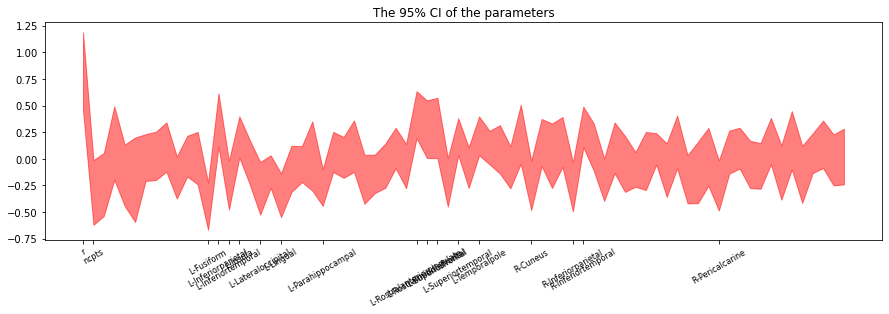

In [67]:
parass_boot = np.array(parass_boot)
lows, ups = coefs_final-parass_boot.std(axis=0)*1.96, coefs_final+parass_boot.std(axis=0)*1.96
kpidxBoot = np.bitwise_or(lows >0,  ups < 0)
kpidxIdBoot = np.where(kpidxBoot)[0]

xlabs = np.concatenate([fsName[:-1],
                         region_names])
plt.figure(figsize=[15, 4])
plt.fill_between(list(range(len(lows))), lows, ups, color="red", alpha=.5)
plt.title("The 95% CI of the parameters")
_ = plt.xticks(kpidxIdBoot, xlabs[kpidxIdBoot], rotation=30, fontsize=8)

select_fs_idx = kpidxBoot;

In [68]:
# Pvalue
test_stats_boot = coefs_final/parass_boot.std(axis=0)
normRV = norm()
# to be consistent, I think we should use two-sided pvalue
bootPvs = 2*(1-normRV.cdf(np.abs(test_stats_boot)))
bootPvs

array([1.10895869e-05, 4.09273166e-02, 1.11810521e-01, 4.02959178e-01,
       2.91617590e-01, 3.30720025e-01, 9.20621647e-01, 8.12535733e-01,
       3.49118396e-01, 8.07534853e-02, 7.99592672e-01, 9.62844575e-01,
       9.29641540e-05, 4.28691495e-03, 3.31693926e-02, 3.70087466e-02,
       7.61496385e-01, 2.76785270e-02, 1.25231189e-01, 1.11163317e-03,
       3.95215034e-01, 5.62322171e-01, 8.73157128e-01, 2.15164387e-03,
       5.02803243e-01, 8.92788609e-01, 3.39583143e-01, 1.00253267e-01,
       1.25617717e-01, 5.40129417e-01, 2.96948099e-01, 5.16261505e-01,
       2.28890733e-04, 4.49046850e-02, 4.52060762e-02, 5.62367764e-02,
       1.89435170e-02, 3.95934119e-01, 2.09618383e-02, 1.90714841e-01,
       4.46242574e-01, 4.23603040e-01, 1.01627662e-01, 3.43712370e-02,
       1.74918210e-01, 8.54002256e-01, 1.86634174e-01, 2.55295702e-02,
       2.15225510e-03, 3.31783851e-01, 5.34263597e-02, 3.99079489e-01,
       7.19498644e-01, 2.28768765e-01, 8.81274475e-01, 2.16305709e-01,
      

In [69]:
# Bootstrap p value and CI are consistent
tmpIdx = np.bitwise_xor(bootPvs <= 0.05, kpidxBoot)
resDic = {
   "Feature" : xlabs[tmpIdx],  
    "Parameters": coefs_final[tmpIdx],
    "Lower": lows[tmpIdx],
    "Upper": ups[tmpIdx],
    "Pvalues": bootPvs[tmpIdx]
}
pd.set_option("display.precision", 3)
resDF = pd.DataFrame(resDic)
print(resDF)

Empty DataFrame
Columns: [Feature, Parameters, Lower, Upper, Pvalues]
Index: []


#### The output table 

In [70]:
resDic = {
   "Feature" : xlabs[kpidxBoot],  
    "Parameters": coefs_final[kpidxBoot],
    "Lower": lows[kpidxBoot],
    "Upper": ups[kpidxBoot],
    "Pvalues": bootPvs[kpidxBoot]
}
#pd.set_option("display.precision", 3)
pd.set_option('display.float_format',lambda x : '%.3e' % x)
resDF = pd.DataFrame(resDic)
print(resDF)

                       Feature  Parameters      Lower      Upper   Pvalues
0                            r   8.214e-01  4.550e-01  1.188e+00 1.109e-05
1                        ncpts  -3.164e-01 -6.198e-01 -1.304e-02 4.093e-02
2                   L-Fusiform  -4.449e-01 -6.680e-01 -2.218e-01 9.296e-05
3           L-Inferiorparietal   3.647e-01  1.144e-01  6.149e-01 4.287e-03
4           L-Inferiortemporal  -2.483e-01 -4.768e-01 -1.982e-02 3.317e-02
5                     L-Insula   2.057e-01  1.240e-02  3.991e-01 3.701e-02
6           L-Lateraloccipital  -2.779e-01 -5.252e-01 -3.052e-02 2.768e-02
7                    L-Lingual  -3.418e-01 -5.473e-01 -1.364e-01 1.112e-03
8            L-Parahippocampal  -2.699e-01 -4.423e-01 -9.751e-02 2.152e-03
9   L-Rostralanteriorcingulate   4.142e-01  1.939e-01  6.345e-01 2.289e-04
10      L-Rostralmiddlefrontal   2.774e-01  6.299e-03  5.485e-01 4.490e-02
11           L-Superiorfrontal   2.894e-01  6.176e-03  5.727e-01 4.521e-02
12          L-Superiortem

In [71]:
abs_paras = np.array(resDF["Parameters"].abs())
raw_bds = np.array(resDF[["Lower", "Upper"]].abs())
abs_low_bd = np.min(raw_bds, axis=1)
abs_up_bd = np.max(raw_bds, axis=1)
pvs = np.array(resDF["Pvalues"])
outDF = {"Features": np.array(resDF["Feature"]),
        "Params": abs_paras, 
        "Lower":abs_low_bd, 
        "Upper":abs_up_bd, 
        "Pvals":pvs}
outDF = pd.DataFrame(outDF)
print(outDF.to_latex(float_format="{:0.3f}".format))

\begin{tabular}{llrrrr}
\toprule
{} &                    Features &  Params &  Lower &  Upper &  Pvals \\
\midrule
0  &                           r &   0.821 &  0.455 &  1.188 &  0.000 \\
1  &                       ncpts &   0.316 &  0.013 &  0.620 &  0.041 \\
2  &                  L-Fusiform &   0.445 &  0.222 &  0.668 &  0.000 \\
3  &          L-Inferiorparietal &   0.365 &  0.114 &  0.615 &  0.004 \\
4  &          L-Inferiortemporal &   0.248 &  0.020 &  0.477 &  0.033 \\
5  &                    L-Insula &   0.206 &  0.012 &  0.399 &  0.037 \\
6  &          L-Lateraloccipital &   0.278 &  0.031 &  0.525 &  0.028 \\
7  &                   L-Lingual &   0.342 &  0.136 &  0.547 &  0.001 \\
8  &           L-Parahippocampal &   0.270 &  0.098 &  0.442 &  0.002 \\
9  &  L-Rostralanteriorcingulate &   0.414 &  0.194 &  0.634 &  0.000 \\
10 &      L-Rostralmiddlefrontal &   0.277 &  0.006 &  0.548 &  0.045 \\
11 &           L-Superiorfrontal &   0.289 &  0.006 &  0.573 &  0.045 \\
12 &     

In [72]:
fsDic = {
   "Feature" : xlabs[:-68],  
    "Parameters": coefs_final[:-68],
    "Lower": lows[:-68],
    "Upper": ups[:-68],
    "Pvalues": bootPvs[:-68]
}
#pd.set_option("display.precision", 3)
pd.set_option('display.float_format',lambda x : '%.3e' % x)
fsDF = pd.DataFrame(fsDic)
print(fsDF.to_latex(float_format="{:0.3f}".format))

\begin{tabular}{llrrrr}
\toprule
{} & Feature &  Parameters &  Lower &  Upper &  Pvalues \\
\midrule
0 &       r &       0.821 &  0.455 &  1.188 &    0.000 \\
1 &   ncpts &      -0.316 & -0.620 & -0.013 &    0.041 \\
2 &  mean\_Q &      -0.240 & -0.537 &  0.056 &    0.112 \\
3 &  mean\_L &       0.147 & -0.198 &  0.493 &    0.403 \\
4 &   var\_Q &      -0.155 & -0.443 &  0.133 &    0.292 \\
5 &   var\_L &      -0.197 & -0.593 &  0.200 &    0.331 \\
\bottomrule
\end{tabular}



In [64]:
# save brain
# final parameter, abs, remove pv <0.05
tmp_n = len(fsName[:]) - 1
oPParas = minmax(np.abs(coefsFinal[tmp_n:]))
NLogPvs = -np.log10(bootPvs[tmp_n:])
oPParas[NLogPvs < -np.log10(0.05)] = 0
outOPParas = U2BrainVec(reorderU(oPParas))

np.savetxt(f"./brainPlotFils/{preFix}_reg1_finalabsOPParas.txt", outOPParas)
pd.DataFrame({"Name": regionNames,
              "Vec": oPParas}).to_csv(f"./brainPlotFils/{preFix}_reg1_finalabsOPParas.csv", index=False)

In [74]:
np.sort(oPParas)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.49920943,
       0.54302721, 0.55686299, 0.57083105, 0.57618043, 0.58901621,
       0.62228241, 0.6493124 , 0.67054834, 0.69654532, 0.74007223,
       0.91866985, 0.93088569, 1.        ])